第五章

`原始内容由Cam Davidson-Pilon创建`

`由Max Margenot（@clean_utensils）和Thomas Wiecki（@twiecki）在Quantopian（@quantopian）上迁移到Python 3和PyMC3`

`由Kurisu Chan（@miemiekurisu）最后迁移到PyMC`
____

### 你更愿意失去一只手臂还是一条腿？

统计学家可能是一群有点刻薄的人。他们不考虑自己赢得了什么，只衡量自己输掉了多少。事实上，他们把自己的赢利视为*负面损失*。但有趣的是*他们如何衡量自己的损失*。

比如，考虑以下例子：

一个气象学家正在预测可能会袭击他所在城市的飓风的概率。他估计，以95%的置信度，它*不会*袭击的概率在99% -100%之间。他对自己的准确性非常满意，劝告城市不必进行大规模疏散。不幸的是，飓风确实袭击了，城市被洪水淹没。

这个程式化的例子展示了使用纯粹的准确度指标衡量结果的缺陷。使用强调估计准确性的度量，虽然是一件吸引人的且客观的事情，但忽略了你为何要进行统计推断的关键点：推断的结果。《黑天鹅》和《反脆弱》的作者纳西姆·塔勒布强调决策的*回报*的重要性，而不是准确性。他非常简洁地概括了这一点：“我宁愿粗略地正确，也不愿非常错误。”

## 损失函数

我们介绍统计学家和决策理论家称之为*损失函数*。损失函数是真实参数和该参数的估计的函数

$$ L( \theta, \hat{\theta} ) = f( \theta, \hat{\theta} ) $$

损失函数的重要点在于它衡量了我们当前估计有多么“糟糕”：损失越大，根据损失函数的估计就越糟糕。一个简单且非常常见的例子是*平方误差损失*：

$$ L( \theta, \hat{\theta} ) = ( \theta -  \hat{\theta} )^2 $$

平方误差损失函数被用于估计器如线性回归，UMVUEs和许多机器学习领域。我们也可以考虑一个非对称的平方误差损失函数，比如：

$$ L( \theta, \hat{\theta} ) = \begin{cases} ( \theta -  \hat{\theta} )^2 & \hat{\theta} \lt \theta \\\\ c( \theta -  \hat{\theta} )^2 & \hat{\theta} \ge \theta, \;\; 0\lt c \lt 1 \end{cases} $$

表示估计一个大于真实估计值的值比估计一个小于真实估计值的值更可取。这可能在估计下个月的网络流量时有用，这样可以避免服务器资源不足的情况。

平方误差损失的一个负面特性是它不成比例地强调了大的异常值。这是因为损失的增加是二次的，而不是线性的，当估计值偏离时。也就是说，与真值相距三个单位的惩罚远小于与真值相距五个单位的惩罚，但惩罚并不比与真值相差一个单位大得多，尽管在这两种情况下，差异的程度是相同的：

$$ \frac{1^2}{3^2} \lt \frac{3^2}{5^2}, \;\; \text{尽管} \;\; 3-1 = 5-3 $$

这个损失函数要求大误差是*非常*糟糕的。一个更*稳健*的损失函数，随着差异线性增加的是*绝对损失*

$$ L( \theta, \hat{\theta} ) = | \theta -  \hat{\theta} | $$

其它流行的损失函数包括：

-  $L( \theta, \hat{\theta} ) = \mathbb{1}_{ \hat{\theta} \neq \theta }$ 是机器学习分类算法中经常使用的零一损失。
-  $L( \theta, \hat{\theta} ) = -\theta\log( \hat{\theta} ) - (1- \theta)\log( 1 - \hat{\theta} ), \; \; \theta \in {0,1}, \; \hat{\theta} \in [0,1]$, 名为*对数损失*，也被用于机器学习。

在历史上，损失函数的动机主要包括1) 数学便利性，和2) 它们对应用是稳健的，即它们是损失的客观度量。第一个原因实际上限制了损失函数的全部广度。由于计算机对数学便利性是不可知的，我们可以自由设计自己的损失函数，在本章的后面我们将充分利用。

对于第二点，上述损失函数的确是客观的，因为它们通常是估计与真实参数之间的差异的函数，独立于选择估计的标志或回报。然而，这最后一点，即与回报的独立性，会导致一些病态结果。考虑上面我们的飓风例子：统计学家等效地预测飓风袭击的概率在0%到1%之间。但如果他忽略了精度，而是专注于结果（99%的可能性没有洪水，1%的可能性的洪水），他可能会给出不同的建议。

通过将我们的关注点从试图对参数估计非常精确转移到聚焦于参数估计结果，我们可以定制我们的估计以优化我们的应用。这要求我们设计反映我们目标和结果的新的损失函数。一些更有趣的损失函数的例子：

- $L( \theta, \hat{\theta} ) = \frac{ | \theta - \hat{\theta} | }{ \theta(1-\theta) }, \; \; \hat{\theta}, \theta \in [0,1]$ 强调估计值接近0或1，因为如果真值$\theta$接近0或1，损失会非常大，除非$\hat{\theta}$也同样接近0或1。这种损失函数可能被政治评论员使用，其工作要求他们给出自信的“是/否”答案。此损失反映了如果真实参数接近1（例如，如果一个政治结果非常可能发生），他们会强烈同意，以免显得怀疑。

-  $L( \theta, \hat{\theta} ) = 1 - \exp \left( -(\theta -  \hat{\theta} )^2 \right)$ 介于0和1之间，并反映用户对足够远的估计不关心。它类似于上面的零一损失，但对于接近真实参数的估计并不如上面的损失惩罚严重。

-  复杂的非线性损失函数可以被编程：

        def loss(true_value, estimate):
            if estimate*true_value > 0:
                return abs(estimate - true_value)
            else:
               return abs(estimate)*(estimate - true_value)**2

-  另一个例子来自书籍*信号与噪声*。气象预报员对他们的预测有一个有趣的损失函数。

>  人们注意一种类型的错误&mdash;未能预测雨&mdash;比其他错误，虚警更加引人注目。如果下雨却没有预测到，他们会因此而责骂气象预报员破坏了他们的野餐，而意外的晴天被视为意外的好处。

>  [天气频道的倾向] 限于在不太可能发生时略微夸张下雨的概率 &mdash; 在真正是5%或10%的几率时说有20%的几率 &mdash; 在出现出乎意料的小雨的情况下来掩护自己。

正如你所见，损失函数可以用于好和坏：大权力会伴随大&mdash;你懂的。

在现实世界中的损失函数

到目前为止，我们一直在假设我们知道真实参数，这是不现实的。当然，如果我们知道真实参数，那么猜测一个估计是没有意义的。因此，损失函数只有在真实参数未知的情况下才实际可行。

在贝叶斯推断中，我们有一个思维模式，即未知参数实际上是具有先验和后验分布的随机变量。就后验分布而言，从中抽取的值是真实参数可能的实现。在给定这种实现的情况下，我们可以计算与估计相关的损失。由于我们拥有未知参数可能的整个分布（后验分布），我们应该更感兴趣地计算给定估计值的*期望损失*。这种期望损失是对真实损失的更好估计，而不是仅比较来自后验的单个样本的给定损失。

首先解释一个*贝叶斯点估计*将会很有用。现代世界中存在的系统和机械不是建立在接受后验分布作为输入之上的。当别人要求一个估计时，把一个分布交给别人是不礼貌的。在个人的一天中，当面对不确定性时，我们仍然会通过将不确定性浓缩到一个行动中来行事。同样，我们需要将后验分布浓缩到一个单个值（或在多变量情况下为向量）。如果智能地选择这个值，我们就可以避免频率方法的缺陷，它们掩盖了不确定性，提供了更具信息性的结果。如果从贝叶斯后验中选择的值是一个贝叶斯点估计。

假设$P(\theta | X)$是在观察数据$X$后$\theta$的后验分布，那么下面的函数可以理解为*选择估计$\hat{\theta}$估计$\theta$而导致的期望损失*：

$$ l(\hat{\theta} ) = E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$

这也被称为估计$\hat{\theta}$的*风险*。期望符号下的下标$\theta$用于表示在期望中未知的（随机）变量$\theta$，这一点起初可能很难考虑。

我们在上一章中讨论了如何逼近期望值。给定$N$个样本$\theta_i,\; i=1,...,N$从后验分布中，以及一个损失函数$L$，我们可以通过大数定律来近似使用估计$\hat{\theta}$的期望损失：

$$\frac{1}{N} \sum_{i=1}^N \;L(\theta_i, \hat{\theta} ) \approx E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right]  = l(\hat{\theta} ) $$

注意，通过*期望值*来衡量你的损失会利用来自分布的更多信息，而不像最大后验估计那样，它只会找到分布的最大值并忽略分布的形状。忽略信息可能会使您过度暴露于尾风险，如不太可能的飓风，并使您的估计忽视有关参数的真实无知。

类似地，将这与传统上仅旨在最小化误差的频率方法进行比较，它不考虑与该误差结果相关的*损失*。结合事实，频率方法几乎不太可能绝对精确。贝叶斯点估计通过提前计划来解决这个问题：你的估计结果将是错误的，你最好偏向错误的正确一面。

优化《价格之王》*Showcase*

如果你曾经被选为《价格之王》的参赛者，那么祝贺你，因为在这里我们将向你展示如何优化你在*Showcase*中的最终价格。对于那些忘记规则的人：

1. 两名参赛者竞争*Showcase*。
2. 每位参赛者展示一套独特的奖品。
3. 在展示之后，参赛者被要求对他们独特奖品套装的价格进行竞标。
4. 如果竞标价高于实际价格，竞标者将被取消获胜资格。
5. 如果竞标价低于真实价格不到250美元，获胜者将获得两个奖品。

游戏的难度在于平衡你对价格的不确定性，保持竞标的价格低于最高价，同时尽可能接近价格。

假设我们已经记录了以前《价格之王》节目中*Showcase*的数据，并对真实价格的分布有一些*先验*信念。为简单起见，假设它遵循正态分布：

$$\text{True Price} \sim \text{Normal}(\mu_p, \sigma_p )$$

在后面的章节中，我们将实际使用*真实《价格之王》Showcase数据*形成历史性先验，但这需要一些高级的PyMC使用，因此我们在这里不会使用。现在，我们假设$\mu_p = 35 000$和$\sigma_p = 7500$。

我们需要一个*Showcase*中应该如何玩的模型。对于奖品套装中的每个奖品，我们都有关于其可能成本的想法，但这个猜测可能与真实价格相差很大。（加上在舞台上的增加压力，你可以看到为什么有些出价离谱）。假设对于奖品价格您的信念也遵循正态分布：

$$ \text{Prize}_i \sim \text{Normal}(\mu_i, \sigma_i ),\;\; i=1,2$$

这正是为什么贝叶斯分析如此出色的原因：我们可以通过$\mu_i$参数来指定我们认为的公平价格，并通过$\sigma_i$参数表示对猜测的不确定性。

我们将假设奖品套装中有两个奖品以简洁起见，但这可以扩展到任意数量。奖品套装的真实价格由$\text{Prize}_1 + \text{Prize}_2 + \epsilon$给出，其中$\epsilon$是某种误差项。

我们对观察到的两个奖品的套装的真实价格感兴趣，并对它们有信念分布。我们可以使用PyMC来执行此操作。

让我们将一些值具体化。假设观察到的奖品套装中有两个奖品：

1. 精彩的加拿大多伦多之旅！
2. 可爱的新除雪机！

我们对这些物品的真实价格有一些猜测，但我们也对它们相当不确定。我可以通过正态分布的参数来表示这种不确定性：

\begin{align}
& \text{除雪机} \sim \text{Normal}(3 000, 500 )\\\\
& \text{多伦多} \sim \text{Normal}(12 000, 3000 )\\\\
\end{align}

例如，我相信多伦多之旅的真实价格为12000美元，并且在这个价格周围有一个标准差内的价格的概率为68.2%，即我的信心是这次旅行在[9 000, 15 000]的范围内的概率为68.2%。

我们可以创建一些PyMC代码来对套装的真实价格进行推断。

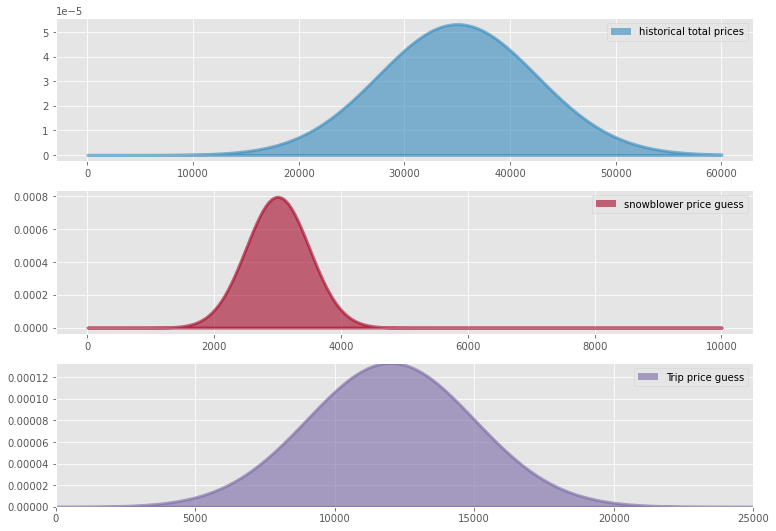

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtl
mtl.style.use("ggplot")

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x , 0, norm_pdf(x, 35000, 7500), 
                color = "#348ABD", lw = 3, alpha = 0.6,
                label = "historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x , 0, norm_pdf(x, 3000, 500), 
                 color = "#A60628", lw = 3, alpha = 0.6,
                 label="snowblower price guess")

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x , 0, norm_pdf(x, 12000, 3000), 
                 color = "#7A68A6", lw = 3, alpha = 0.6,
                 label = "Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

In [4]:
import pymc as pm

data_mu = [3e3, 12e3]

data_std =  [5e2, 3e3] 

mu_prior = 35e3
std_prior =  75e2
with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sigma=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sigma=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sigma=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.logp(pm.Normal.dist(mu=price_estimate, sigma=(3e3)),true_price)
    error = pm.Potential("error", logp)
    

    trace = pm.sample(50000, tune=10000,chains=1)
    # burned_trace = trace[10000:]

price_trace = trace.posterior.true_price.data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [true_price, first_prize, second_prize]


Sampling 1 chain for 10_000 tune and 50_000 draw iterations (10_000 + 50_000 draws total) took 21 seconds.


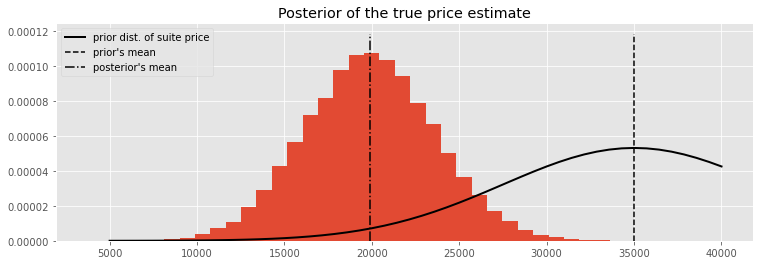

In [4]:
figsize(12.5, 4)

import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, 
         label = "prior dist. of suite price")

_hist = plt.hist(price_trace[0], bins = 35, density= True, histtype= "stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label = "prior's mean",
           linestyles="--",color="black")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), \
           label = "posterior's mean", linestyles="-.",color="black")
plt.legend(loc = "upper left");

请注意，由于我们观察到的两个奖品和随后的猜测（包括对这些猜测的不确定性），我们将平均价格估计从之前的平均价格下调了约$15,000美元。

一个经验主义者看到两个奖品且对它们的价格持有相同的信念，将出价$\mu_1 + \mu_2 = 35000$，无论有任何不确定性。与此同时，*天真的贝叶斯人*将简单地选择后验分布的平均值。但我们有关于最终结果的更多信息；我们应该将这些信息纳入我们的出价。我们将使用上面的损失函数来找到*最佳*出价（根据我们的损失）。

一个参赛者的损失函数可能是什么样的？我认为它可能如下所示：

```
def showcase_loss(guess, true_price, risk=80000):
    if true_price < guess:
        return risk
    elif abs(true_price - guess) <= 250:
        return -2*np.abs(true_price)
    else:
        return np.abs(true_price - guess - 250)
```

其中`risk`是一个参数，定义了如果您的猜测高于真实价格的话，情况有多糟糕。较低的`risk`意味着您对超出价格的想法更加舒适。如果我们投标低且差距小于250美元，则我们会获得两个奖品（在这里被建模为获得原始奖品的两倍）。否则，当我们投标低于`true_price`时，我们希望尽可能接近，因此`else`的损失是猜测和真实价格之间距离的一个递增函数。

对于每一个可能的出价，我们计算与该出价相关的*预期损失*。我们改变`风险`参数来看看它会如何影响我们的损失：

(5000.0, 30000.0)

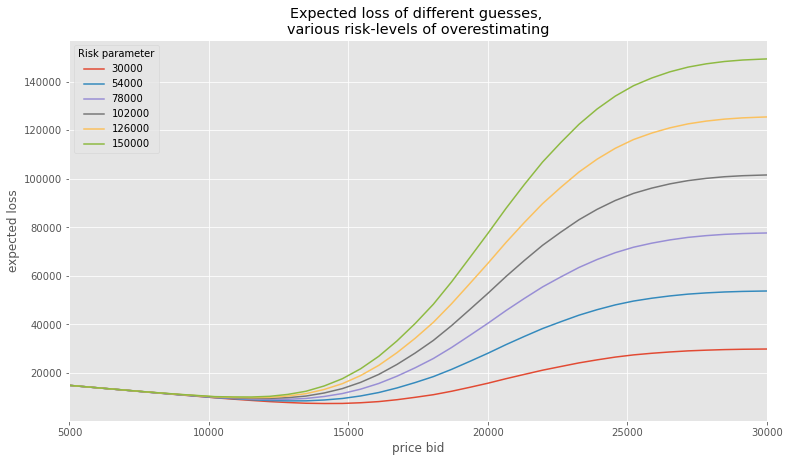

In [5]:
figsize(12.5, 7)
#numpy friendly showdown_loss


def showdown_loss(guess, true_price, risk = 80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = abs(true_price - guess) <= 250
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70) 
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)
    
plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000)

### 减少我们的损失

选择最小化我们预期损失的估计是明智的选择。这对应于上述每个曲线上的最小点。更正式地说，我们希望通过找到以下方程的解来最小化我们的预期损失：

$$ \text{arg} \min_{\hat{\theta}} \;\;E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$

预期损失的最小值称为*贝叶斯动作*。我们可以使用Scipy的优化例程来求解贝叶斯动作。 `scipy.optimize` 模块中的 `fmin` 函数使用智能搜索来找到任何单变量或多变量函数的最小值（不一定是*全局*最小值）。对于大多数情况，`fmin` 将为您提供一个很好的答案。

我们将计算上面*Showcase*示例的最小损失。

minimum at risk 30000: 14189.71
minimum at risk 54000: 13242.36
minimum at risk 78000: 12143.58
minimum at risk 102000: 12143.58
minimum at risk 126000: 11485.25
minimum at risk 150000: 11041.61


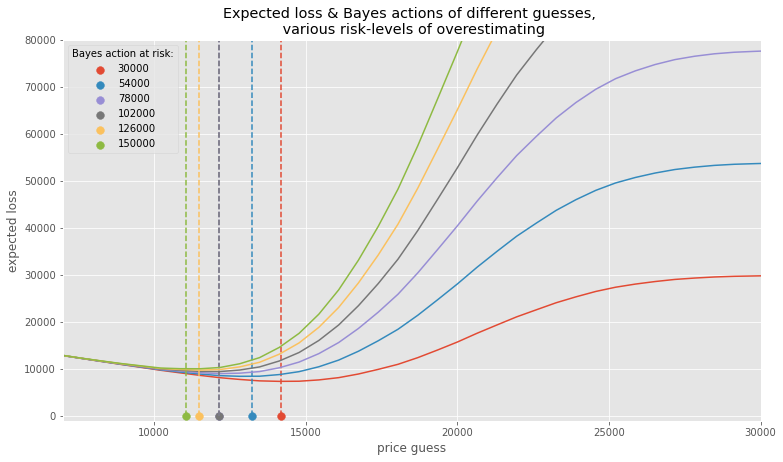

In [6]:
import scipy.optimize as sop

ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))
                                    
plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints = 1, title = "Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

正如直觉所提示的那样，随着我们降低风险门槛（更少地关心过高出价），我们会增加出价，愿意更接近真实价格。有趣的是，我们优化的损失与后验均值相差多远，后验均值约为20,000。

可以说，在更高维度中，能够凭直觉估计最小期望损失是不可能的。这就是为什么我们需要使用Scipy的`fmin`函数的原因。

### 快捷方式

对于一些损失函数而言，贝叶斯动作可以用封闭形式表示。我们以下列出其中的一些：

- 如果使用均方损失，贝叶斯动作是后验分布的均值，即值 $$ E_{\theta}\left[ \theta \right] $$ 最小化了 $E_{\theta}\left[ \; (\theta - \hat{\theta})^2 \; \right]$。在计算上，这要求我们计算后验样本的平均值[见第4章关于大数定律]

- 后验分布的*中位数*最小化了期望的绝对损失。后验样本的样本中位数是对真实中位数的适当和非常准确的近似。

- 实际上，我们可以表明MAP估计是使用一个收缩到0-1损失的损失函数的解。

也许现在为什么在贝叶斯推断的数学中最常使用最早引入的损失函数已经很清楚：我们不需要进行复杂的优化。幸运的是，我们有机器来替我们处理这些复杂性。

## 通过贝叶斯方法进行机器学习

频率主义方法力求获得关于所有可能参数的最佳精度，而机器学习则致力于在所有可能参数中实现最佳*预测*。当然，实现准确的预测是获得精确预测的一种方式，但是通常你的预测衡量和频率主义方法正在优化的内容是非常不同的。

例如，最小二乘线性回归是最简单的主动机器学习算法。我说它是主动的是因为它进行了一些学习，虽然预测样本均值在技术上更*简单*，但是却几乎没有进行学习。决定回归系数的损失是平方误差损失。另一方面，如果你的预测损失函数（或得分函数，即负损失）不是平方误差，如AUC、ROC、精度等，你的最小二乘线可能不会对预测损失函数最优。这可能导致预测结果不够理想。

寻找贝叶斯动作等同于寻找优化*非参数准确性*而是任意性能度量的参数，我们希望定义性能（损失函数、AUC、ROC、精度/召回率等）。

接下来的两个例子演示了这些想法。第一个例子是一个线性模型，我们可以选择使用最小二乘损失或者一种新颖的、结果敏感的损失进行预测。

第二个例子是从一个Kaggle数据科学项目中改编而来。与我们的预测相关的损失函数非常复杂。

假设一支股票价格未来的回报非常小，例如0.01（或1%）。我们有一个可以预测股票未来价格的模型，我们的盈亏直接与我们根据预测采取行动有关。我们应该如何衡量与模型预测及随后未来预测相关的损失呢？一个平方误差损失是不受符号影响的，它会同样惩罚-0.01的预测和0.03的预测：

$$(0.01 - (-0.01))^2 = (0.01 - 0.03)^2 = 0.004$$

如果您基于模型的预测下注，您将会因0.03的预测赚钱，因-0.01的预测而亏钱，然而我们的损失没有捕捉到这一点。我们需要一个更好的损失函数，考虑到预测和真实值的*符号*。我们设计了一个更适用于金融应用的新损失函数如下：

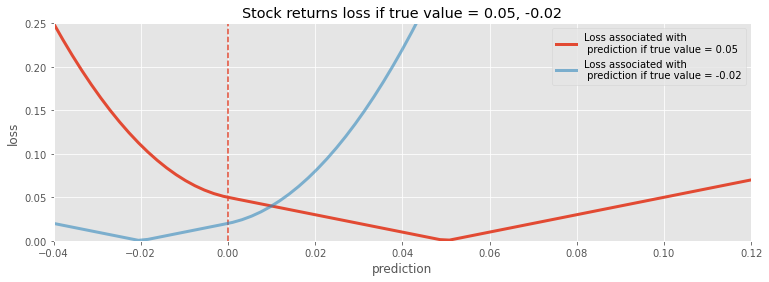

In [8]:
figsize(12.5, 4)


def stock_loss(true_return, yhat, alpha = 100.):
    if true_return * yhat < 0:
        #opposite signs, not good
        return alpha*yhat**2 - np.sign(true_return)*yhat \
                        + abs(true_return) 
    else:
        return abs(true_return - yhat)
    
    
true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], \
        label = "Loss associated with\n prediction if true value = 0.05", lw =3) 
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha = 0.6, \
        label = "Loss associated with\n prediction if true value = -0.02", lw =3) 
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");

请注意随着预测穿过零点，损失形状的变化。这种损失反映出用户真的不想猜错符号，尤其是错了*而且*幅度很大。

用户为什么在意幅度？为什么预测正确符号时损失不为0？当然，如果收益为0.01，我们押注数百万仍然会很高兴。

金融机构处理下行风险，比如错误预测很多，以及上行风险，比如正确预测很多，都是类似的。两者都被视为冒险行为并受到打击。因此，当我们偏离真实价格更远时，损失会逐渐增加。（在正确符号方向上的损失较小。）

我们将对我们认为能够很好预测未来收益的交易信号进行回归分析。我们的数据集是人工生成的，因为大多数金融数据甚至不接近线性。在下面，我们绘制数据以及最小二乘线。

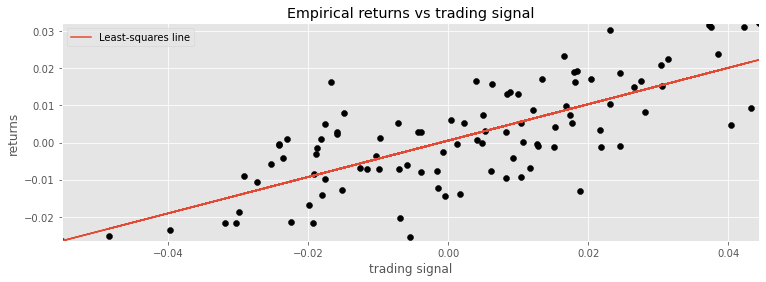

In [9]:
## Code to create artificial data
N = 100
X = 0.025*np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N) 

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label = "Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

我们对这个数据集进行简单的贝叶斯线性回归。我们寻找一个模型：

$$ R = \alpha + \beta x + \epsilon$$

其中 $\alpha, \beta$ 是我们未知的参数，$\epsilon \sim \text{Normal}(0, \sigma)$。$\beta$ 和 $\alpha$ 最常见的先验分布是正态分布。我们还将对 $\sigma$ 分配一个先验，使得 $\sigma$ 在 0 到 100 之间均匀分布。

In [10]:
import pymc as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=0, sigma=100)
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    
    mean = pm.Deterministic("mean", alpha + beta*X)
    
    obs = pm.Normal("obs", mu=mean, sigma=std, observed=Y)
    
    trace = pm.sample()
    # burned_trace = trace[20000:]  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


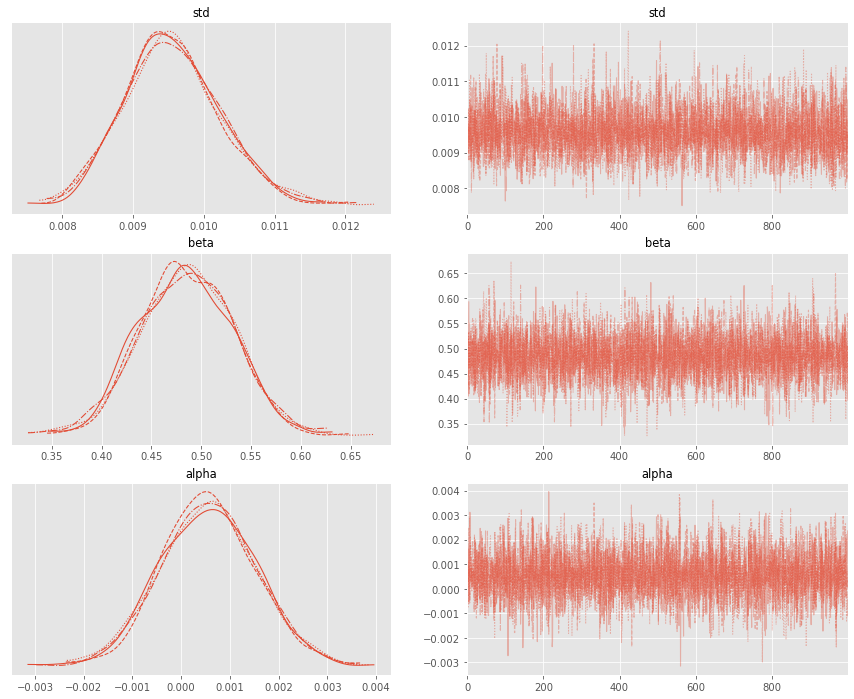

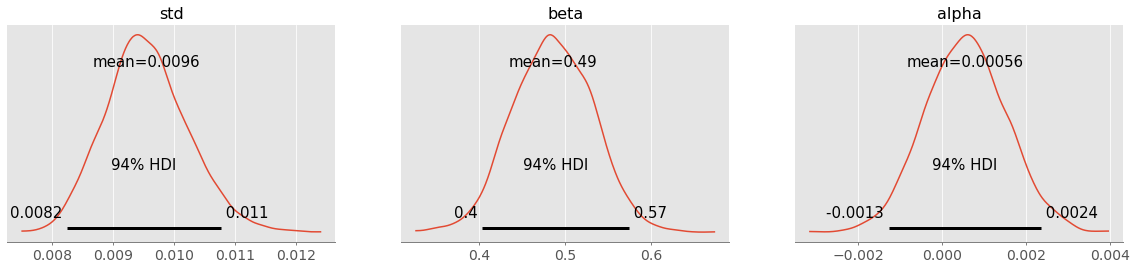

In [11]:
import arviz as az
az.plot_trace(trace, var_names=["std", "beta", "alpha"],figsize=(15, 12))
az.plot_posterior(trace, var_names=["std", "beta", "alpha"],figsize=(20, 4));

似乎MCMC已经收敛，所以我们可以继续。

对于一个特定的交易信号，将其记为 $x$，可能收益的分布形式为：

$$R_i(x) = \alpha_i + \beta_ix + \epsilon$$

其中 $\epsilon \sim \text{Normal}(0, \sigma_i)$，$i$ 表示我们的后验样本。我们希望找到下面的解：

$$\arg \min_{r} \;\;E_{R(x)}\left[ \; L(R(x), r) \; \right]$$

根据上面给定的损失。这个 $r$ 是我们针对交易信号 $x$ 的贝叶斯行动。下面我们绘制了在不同交易信号上的贝叶斯行动。你注意到了什么？

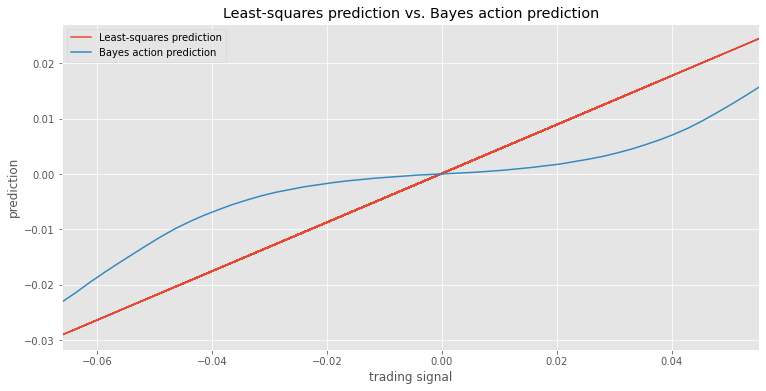

In [11]:
figsize(12.5, 6)
from scipy.optimize import fmin


def stock_loss(price, pred, coef = 500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = trace.posterior["std"].data
alpha_samples = trace.posterior.alpha.data
beta_samples = trace.posterior.beta.data

N = std_samples.shape[1]

noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise


opt_predictions = np.zeros(50)
trading_signals =  np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
        _possible_outcomes = possible_outcomes(_signal)
        tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
        opt_predictions[i] = fmin(tomin, 0, disp = False)
        
        
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label ="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
plt.legend(loc="upper left");

关于上面的图表有趣的地方在于，当信号接近0时，并且许多可能的回报结果可能既是正数又是负数时，我们最佳（就我们的损失而言）的预测是预测接近0，因此*不持有任何头寸*。只有当我们非常确信时，才会进入一个头寸。我称这种模型的风格为*稀疏预测*，在这里我们对不确定性感到不舒服，因此选择不采取行动。（与最小二乘预测相比，后者很少会预测为零）。

一个很好的检验我们的模型是否仍然合理：随着信号变得越来越极端，我们对回报的正面/负面性感到越来越自信，我们的头寸会与最小二乘线收敛。

稀疏预测模型并不试图*最佳拟合*数据（根据*平方误差损失*定义的*拟合*）。这一荣誉将由最小二乘模型获得。稀疏预测模型试图找到*就我们定义的`stock_loss`损失而言的最佳预测*。我们可以反过来进行推理：最小二乘模型并不试图*最佳预测*（根据*`stock-loss`*定义的*预测*）。这一荣誉将属于*稀疏预测*模型。最小二乘模型试图找到数据*就平方误差损失而言的最佳拟合*。

Kaggle关于*观察暗物质*比赛

学习贝叶斯方法的个人动机之一是试图拼凑出Kaggle的[*观察暗世界*](http://www.kaggle.com/c/DarkWorlds)比赛的获胜解决方案。从比赛网站上得知：

> 宇宙中有更多的事物超出了我们的眼睛。在宇宙中存在一种形式的物质，其数量几乎是我们可以看到的东西的7倍，且我们不知道它是什么。我们知道的是它不发出或吸收光，因此我们称之为暗物质。如此庞大的聚集物质不会被忽视。实际上，我们观察到这种物质聚集并形成称为暗物质晕的大型结构。尽管黑暗，它扭曲和弯曲了时空，使任何经过暗物质附近的背景星系的光路改变并扭曲。这种弯曲导致星系在天空中看起来像一个椭圆。

比赛要求预测暗物质可能存在的位置。获胜者[Tim Salimans](http://timsalimans.com/)使用贝叶斯推断找到了最佳的暗物质晕的位置（有趣的是，第二名也使用了贝叶斯推断）。在Tim的允许下，我们在这里提供了他的解决方案[1]：

1. 构建暗物质晕位置的先验分布$p(x)$，即在查看数据之前对暗物质晕位置的期望进行建模。
2. 建立给定暗物质晕位置情况下数据的概率模型（星系的椭圆度）：$p(e|x)$。
3. 使用贝叶斯定理得到暗物质晕位置的后验分布，即使用数据猜测暗物质晕可能的位置。
4. 最小化基于后验分布的预测对于暗物质晕位置的期望损失：$\hat{x}=\arg\min_{\text{prediction}} E_{p(x|e)}[ L(\text{prediction}, x) ]$，即调整我们的预测以使其在给定的误差度量下尽可能好。

这个问题中的损失函数非常复杂。对于那些非常决心的人来说，损失函数包含在父文件夹中的DarkWorldsMetric.py文件中。虽然我建议不要全部阅读，但可以说损失函数大约有160行代码 - 不是可以用单一数学公式写下的东西。损失函数试图以欧几里得距离的方式来衡量预测的准确性，以确保没有任何偏移。有关更多细节，请查看度量标准的[主页](http://www.kaggle.com/c/DarkWorlds/details/evaluation)。

我们将尝试使用PyMC和我们对损失函数的知识来实施Tim的获胜解决方案。

### 数据

数据集实际上是300个单独的文件，每个文件代表一个天空。在每个文件或天空中，有300到720个星系。每个星系都有与之关联的$x$和$y$位置，范围从0到4200，并且有椭圆度的测量值：$e_1$和$e_2$。关于这些测量值的含义可以在[这里](https://www.kaggle.com/c/DarkWorlds/details/an-introduction-to-ellipticity)找到，但就我们的目的而言，除了可视化目的之外并不重要。因此，一个典型的天空可能看起来像下面这样：

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]


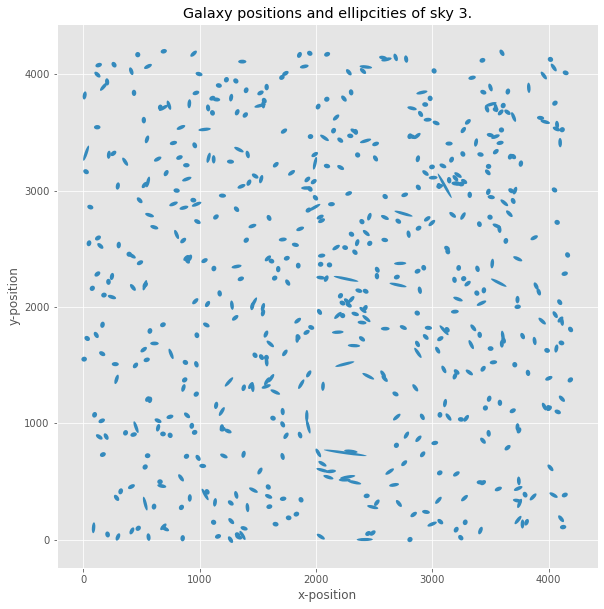

In [15]:
from draw_sky2 import draw_sky

n_sky = 3 #choose a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");

### 先验

每个天空中都有一个、两个或三个暗物质暗物质晕。Tim的解决方案详细说明了他的暗物质位置的先验分布是均匀的，即

\begin{align}
& x_i \sim \text{Uniform}(0, 4200)\\\\
& y_i \sim \text{Uniform}(0, 4200), \;\; i=1,2,3\\\\
\end{align}

Tim和其他竞争者注意到，大多数天空有一个大型暗物质晕和其他晕，如果有的话，会小得多。较大的物质晕，具有更多的质量，会对周围的星系产生更大的影响。他决定大型暗物质晕的质量将分布为一个介于40和180之间的*log*-均匀随机变量，即

$$ m_{\text{large}} = \log \text{Uniform}(40, 180) $$

在PyMC中，

    exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
    mass_large = pm.Deterministic("mass_large", np.log(exp_max_large))

（这就是我们所说的*log*-均匀。）对于较小的星系，Tim将质量设置为20的对数。为什么Tim没有为较小的质量创建先验，也没有将其视为未知数？我认为这个决定是为了加快算法的收敛速度。这并不是太严格的限制，因为按照构造，较小的暗物质晕对星系的影响较小。

Tim合理地假设每个星系的椭圆度取决于暗物质晕的位置，星系与暗物质晕之间的距离以及暗物质晕的质量。因此，每个星系的椭圆度向量$ \mathbf{e}_i $是（我们将形式化）暗物质晕位置向量$(\mathbf{x},\mathbf{y})$、距离和暗物质晕质量的“子”变量。

Tim通过阅读文献和论坛帖子构想了一个将位置和椭圆度联系起来的关系。他认为以下关系是合理的：

$$ e_i | (\mathbf{x}, \mathbf{y}) \sim \text{Normal}(\sum_{j = \text{halo positions}}d_{i,j} m_j f(r_{i,j}), \sigma^2) $$

其中$ d_{i,j} $是“切向方向”（晕$j$弯曲星系$i$的光线的方向），$ m_j $是晕$j$的质量，$ f(r_{i,j}) $是晕$j$与星系$i$之间的欧氏距离的“递减函数”。

Tim的函数$f$被定义为：

$$ f(r_{i,j}) = \frac{1}{\min(r_{i,j}, 240)} $$

对于大型暗物质晕，对于小晕

$$ f(r_{i,j}) = \frac{1}{\min(r_{i,j}, 70)} $$

这完全连接了我们的观察和未知。这个模型非常简单，Tim提到这种简单性是有意设计的：它可以防止模型过度拟合。

### 训练和PyMC实现

对于每个天空，我们运行我们的贝叶斯模型以找到暗物质晕位置的后验分布-我们忽略（已知的）暗物质晕位置。这与传统的Kaggle竞赛方法稍有不同，其中此模型不使用其他天空的数据或已知的暗物质位置。这并不意味着其他数据是不必要的-实际上，该模型是通过比较不同天空创建的。

In [17]:
import pymc as pm
import pytensor.tensor as pt

def euclidean_distance(x, y):
    return np.sqrt(((x - y)**2)).sum(axis=1)

def f_distance(gxy_pos, halo_pos, c):
    # foo_position should be a 2-d numpy array
    # T.maximum() provides our element-wise maximum as in NumPy, but instead for theano tensors
    return pt.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    # foo_position should be a 2-d numpy array
    delta = glxy_position - halo_position
    t = (2*pt.arctan(delta[:,1]/delta[:,0]))
    return pt.stack([-pt.cos(t), -pt.sin(t)], axis=1)


with pm.Model() as model:
    #set the size of the halo's mass
    mass_large = pm.Uniform("mass_large", 40, 180)
    
    #set the initial prior position of the halos, it's a 2-d Uniform dist.
    halo_position = pm.Uniform("halo_position", 0, 4200, shape=(1,2))
    
    mean = pm.Deterministic("mean", mass_large /\
            f_distance(pt.as_tensor(data[:,:2]), halo_position, 240)*\
            tangential_distance(pt.as_tensor(data[:,:2]), halo_position))
    
    ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])

In [18]:
with model:
    # mu, sds, elbo = pm.variational.advi(n=50000)
    # step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
    # trace = pm.sample(5000, step=step, start=mu)
    
    trace = pm.sample(5000, init='advi', n_init=50000,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 28000
Interrupted at 27,999 [55%]: Average Loss = -107.23
Sequential sampling (1 chains in 1 job)
NUTS: [mass_large, halo_position]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 5 seconds.


我们在这里使用ADVI来为我们的NUTS采样器找到一个良好的起点和缩放。 NUTS是比Metropolis更聪明的MCMC采样方法，因此我们需要更少的总样本使我们的链收敛。 ADVI遵循完全不同的方法来拟合一个模型，这里我们不深入讨论。 我们可能会在以后的章节中深入介绍ADVI以及NUTS。

下面我们绘制一个后验分布的“热图”。（其实就是后验的散点图，但我们可以将其可视化为热图。）

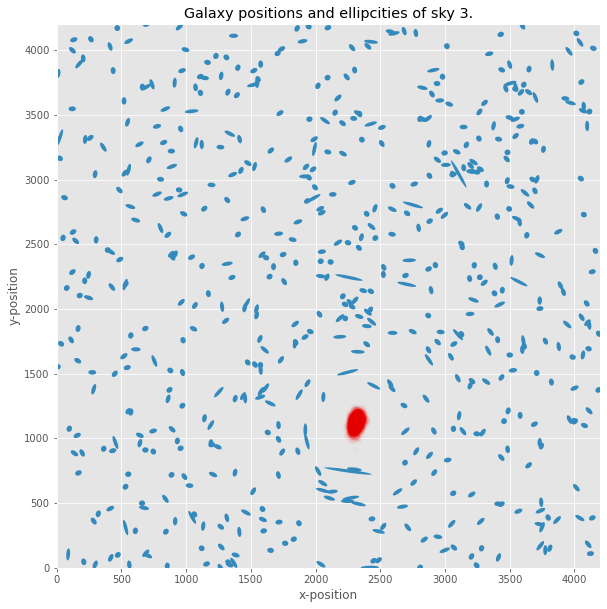

In [19]:
# t = trace["halo_position"].reshape(5000,2)
t = trace.posterior.halo_position.data.reshape(5000,2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

最有可能的位置会显露出来，就像致命的伤口一样。

与每个天空相关联的是另一个数据点，位于`./data/Training_halos.csv`中，其中包含了天空中最多三个暗物质暗云的位置。例如，我们训练过的夜空中有暗云位置：

In [16]:
halo_data = np.genfromtxt("data/Training_halos.csv", 
                          delimiter = ",",
                          usecols = [1, 2,3, 4,5,6,7,8,9],
                          skip_header = 1)
print(halo_data[n_sky])

[1.00000e+00 1.40861e+03 1.68586e+03 1.40861e+03 1.68586e+03 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


第三列和第四列代表了光晕的真实$x$和$y$位置。从结果看，贝叶斯方法已经将光晕定位在一个密集的区域内。

True halo location: 1408.61 1685.86


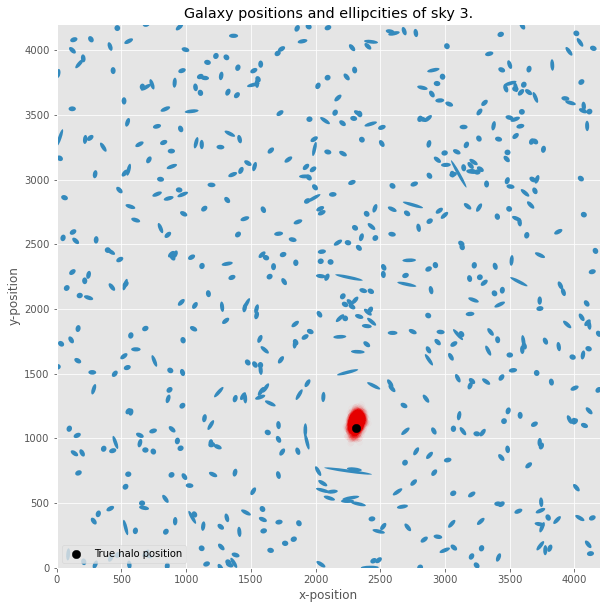

In [17]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4], 
            label = "True halo position",
            c = "k", s = 70)
plt.legend(scatterpoints = 1, loc = "lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

完美。我们的下一步是使用损失函数来优化我们的位置。一个幼稚的策略是简单地选择平均值：

In [18]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print(mean_posterior)

[[2312.20427163 1127.28430251]]


In [19]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky-1]

nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, random_guess)

Using the mean:
Your average distance in pixels you are away from the true halo is 45.47510107521696
Your average angular vector is 0.9999999999999999
Your score for the training data is 1.0454751010752168
Using a random location: [[ 923 3023]]
Your average distance in pixels you are away from the true halo is 2389.0398135862033
Your average angular vector is 1.0
Your score for the training data is 3.389039813586203


3.389039813586203

这是一个不错的猜测，离真实位置并不远，但它忽略了我们提供的损失函数。我们还需要扩展我们的代码，以允许最多两个额外的* 较小星系：让我们创建一个自动化我们的 PyMC 的函数。

In [20]:
def halo_posteriors(n_halos_in_sky, galaxy_data,samples = 5e5, burn_in = 500):
    #set the size of the halo's mass
    with pm.Model() as model:
        mass_large = pm.Uniform("mass_large", 40, 180)
        
        mass_small_1 = 20
        mass_small_2 = 20
    
        masses = np.array([mass_large,mass_small_1, mass_small_2], dtype=object)
    
        #set the initial prior positions of the halos, it's a 2-d Uniform dist.
        halo_positions = pm.Uniform("halo_positions", 0, 4200, shape=(n_halos_in_sky,2)) #notice this size
    
        fdist_constants = np.array([240, 70, 70])
        
        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += masses[i]/f_distance(data[:,:2], halo_positions[i, :], fdist_constants[i])*\
                tangential_distance(data[:,:2], halo_positions[i, :])
        
        mean = pm.Deterministic("mean", _sum)
               
        ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])
    
        # mu, sds, elbo = pm.variational.advi(n=50000)
        # step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
        trace = pm.sample(samples, init='advi', n_init=50000,tune=burn_in,chains=4)
        
    # burned_trace = trace[burn_in:]
    return trace.posterior.halo_positions.data

In [21]:
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])

In [22]:
#there are 3 halos in this file. 
samples = 5000
traces = halo_posteriors(3, data, samples = samples, burn_in=500)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13800
Interrupted at 13,799 [27%]: Average Loss = -120.66
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mass_large, halo_positions]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 257 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6235, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8931, but should be close to 0.8. Try to increase the number of tuning steps.


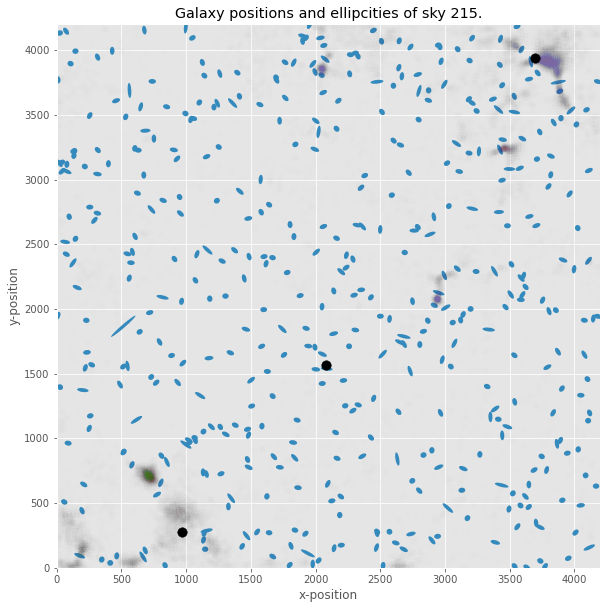

In [23]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces[0].shape[1]):
    plt.scatter(traces[0][:, i, 0],  traces[0][:, i, 1], c = colors[i], alpha = 0.002)
    
    
for i in range(traces.T.shape[1]):
    plt.scatter(halo_data[n_sky-1][3 + 2*i], halo_data[n_sky-1][4 + 2*i], 
            label = "True halo position", c = "k", s = 90)
    
#plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

你可能会注意到，这次我们使用了参数`chains=4`。根据API文档，`运行独立的链对于一些收敛统计很重要，也可以揭示后验中的多个模式`。 这次我们使用4个独立的链来建立更多的信心。

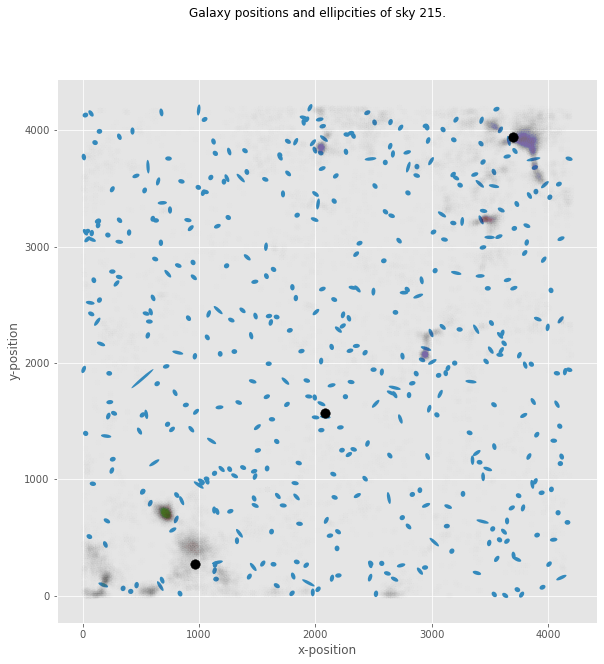

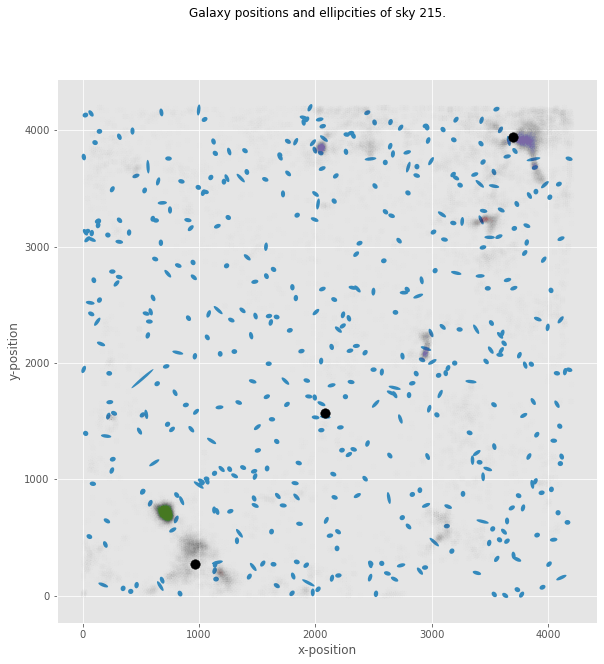

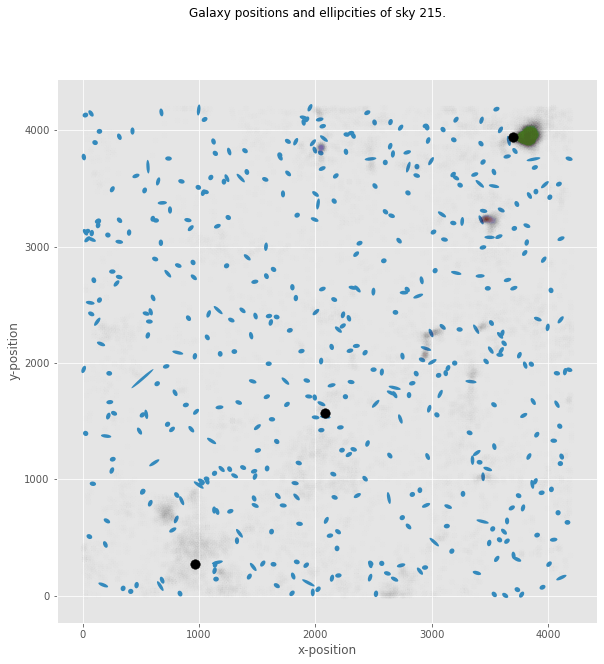

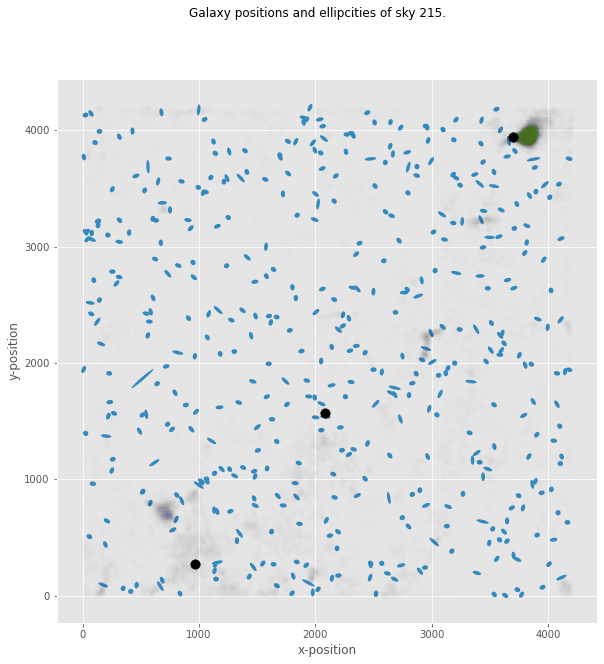

In [24]:
for pt in range(traces.shape[0]):
    fig = draw_sky(data)

    colors = ["#467821", "#A60628", "#7A68A6"]


    for i in range(traces[1].shape[1]):
            plt.scatter(traces[pt][:, i, 0],  traces[pt][:, i, 1], c = colors[i], alpha = 0.002)


    for i in range(traces.T.shape[1]):
        plt.scatter(halo_data[n_sky-1][3 + 2*i], halo_data[n_sky-1][4 + 2*i], 
                label = "True halo position", c = "k", s = 90)

    #plt.legend(scatterpoints = 1)
    # ax[0].xlim(0, 4200)
    # ax[0].ylim(0, 4200)
    plt.suptitle("Galaxy positions and ellipcities of sky %d." % n_sky)
    plt.xlabel("x-position")
    plt.ylabel("y-position")

这看起来相当不错，尽管系统花了很长时间才（基本上）收敛。我们的优化步骤可能会像这样：

In [25]:
_halo_data = halo_data[n_sky-1]
print(traces.shape)

for pt in range(traces.shape[0]): 
    print(f"Independent chains: {pt}")
    mean_posterior = traces[pt].mean(axis=0).reshape(1,6)
    print(mean_posterior)


    nhalo_all =  _halo_data[0].reshape(1,1)
    x_true_all = _halo_data[3].reshape(1,1)
    y_true_all = _halo_data[4].reshape(1,1)
    x_ref_all = _halo_data[1].reshape(1,1)
    y_ref_all = _halo_data[2].reshape(1,1)
    sky_prediction = mean_posterior


    print("Using the mean:")
    main_score([1], x_true_all, y_true_all, \
                x_ref_all, y_ref_all, sky_prediction)

    #what's a bad score?
    random_guess = np.random.randint(0, 4200, size=(1,2))
    print("Using a random location:", random_guess)
    main_score([1], x_true_all, y_true_all, \
                x_ref_all, y_ref_all, random_guess)

(4, 5000, 3, 2)
Independent chains: 0
[[ 779.51700107  347.57575126 2918.9354877  2779.57731108 3001.95900013
  3617.28296252]]
Using the mean:
Your average distance in pixels you are away from the true halo is 4629.09722602648
Your average angular vector is 1.0
Your score for the training data is 5.62909722602648
Using a random location: [[2711  508]]
Your average distance in pixels you are away from the true halo is 3572.625649924716
Your average angular vector is 1.0
Your score for the training data is 4.572625649924716
Independent chains: 1
[[ 843.86621797  508.89191769 2692.97496628 2737.46647823 3333.4681748
  3642.28791824]]
Using the mean:
Your average distance in pixels you are away from the true halo is 4463.5876012667
Your average angular vector is 1.0
Your score for the training data is 5.463587601266701
Using a random location: [[ 524 3851]]
Your average distance in pixels you are away from the true halo is 3173.7457387919403
Your average angular vector is 1.0
Your score f

## 参考资料
1. 反脆弱：从混乱中获益。纽约：随机屋。2012年。ISBN 978-1-4000-6782-4。
2. [蒂姆·萨利曼对暗影世界竞赛的解决方案](http://www.timsalimans.com/observing-dark-worlds)
3. Silver, Nate. 信号与噪音：为什么那么多预测失败——但有些不会。企鹅出版社，2012年。印刷版。

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()